# OPENTIS
## An Example with Alanine

Import Modules

In [1]:
import gc

In [2]:
import numpy as np
import mdtraj as md
import pandas as pd
import time
import sys, os
 
# in principle, all of these imports should be simplified once this is a package
from openpathsampling.collectivevariable import CV_Function, CV_Volume, CV_MD_Function
from openpathsampling.snapshot import Snapshot
from openpathsampling.volume import CVRangeVolumePeriodic, VolumeFactory as vf
from openpathsampling.pathmover import PathMoverFactory as mf
from openpathsampling.ensemble import EnsembleFactory as ef
from openpathsampling.ensemble import (LengthEnsemble, SequentialEnsemble, AllOutXEnsemble,
                      AllInXEnsemble, PartInXEnsemble, PartOutXEnsemble)
from openpathsampling.storage import Storage
from openpathsampling.trajectory import Trajectory
from openpathsampling.pathsimulator import Bootstrapping
from openpathsampling.shooting import UniformSelector
from openpathsampling.pathmover import PathMover, SampleGeneratingMover
import simtk.unit as u

from openpathsampling.openmm_engine import OpenMMEngine

from openpathsampling.storage import Storage
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

import openpathsampling as paths

Radians to Degree conversion

In [3]:
degrees = 180/3.14159 # psi reports in radians; I think in degrees

Create an AlanineOpenMMSimulator for demonstration purposes

### Set simulation options and create a simulator object

In [4]:
options = {
            'temperature' : 300.0 * u.kelvin,
            'collision_rate' : 1.0 / u.picoseconds,
            'timestep' : 2.0 * u.femtoseconds,
            'nsteps_per_frame' : 10,
            'n_frames_max' : 5000,
            'start_time' : time.time(),
            'fn_initial_pdb' : "../data/Alanine_solvated.pdb",
            'platform' : 'fastest',
            'solute_indices' : range(22),
            'forcefield_solute' : 'amber96.xml',
            'forcefield_solvent' : 'tip3p.xml'
           }

In [5]:
engine = OpenMMEngine.auto(
                filename="trajectory.nc",
                template="../data/Alanine_solvated.pdb",
                options=options,
                mode='create'
                )

And save the storage in a separate variable for convenience

In [6]:
storage = engine.storage
paths.EngineGeneratingMover.engine = engine

Equilibrate

In [7]:
engine.current_snapshot = engine.template
engine.equilibrate(5)
engine.initialized = True

Save equilibrated snapshot with index 0

In [8]:
storage.save(engine.current_snapshot);

### Order Parameters

this generates an order parameter (callable) object named psi (so if we call `psi(trajectory)` we get a list of the values of psi for each frame in the trajectory). This particular order parameter uses mdtraj's compute_dihedrals function, with the atoms in psi_atoms

In [9]:
psi_atoms = [6,8,14,16]
psi = CV_MD_Function("psi", md.compute_dihedrals,
                  indices=[psi_atoms])

phi_atoms = [4,6,8,14]
phi = CV_MD_Function("phi", md.compute_dihedrals,
                  indices=[phi_atoms])

In [10]:
storage.save([psi, phi]);

### Volumes

This creates two states using a one-dimensional order parameter (called _Lambda_ in TIS terminology). A snapshot is in the State as long as the order parameter is with specific bounds. 

In [11]:
stateA = CVRangeVolumePeriodic(
    collectivevariable=psi, 
    lambda_min=-120.0/degrees, 
    lambda_max=-30.0/degrees, 
    period_min=-180.0/degrees, 
    period_max=+180.0/degrees
)
stateB = CVRangeVolumePeriodic(psi, 100/degrees, 180/degrees, -180.0/degrees, +180.0/degrees)

Now do the same for a set of lambda ranges to produce nested volumes.

In [12]:
minima = map((1.0 / degrees).__mul__,
             [-125, -135, -140, -142.5, -145.0, -147.0, -150.0])

maxima = map((1.0 / degrees).__mul__,
             [-25.0, -21.0, -18.5, -17.0, -15.0, -10.0, 0.0])

volume_set = vf.CVRangeVolumePeriodicSet(psi, minima, maxima, -180.0/degrees, +180.0/degrees)

### Ensembles

Now do this automatically for all ensembles

In [13]:
interface0 = volume_set[0]
interface_set = ef.TISEnsembleSet(stateA, stateA | stateB, volume_set, psi)
for no, interface in enumerate(interface_set):
    # Give each interface a name
    interface.name = 'Interface '+str(no)
    # And save all of these
    storage.ensembles.save(interface)

And create a special ensemble, that will create a first trajectory in the innermost TIS ensemble independent from where we start

The idea is to describe a trajectory type by a sequence of positions. First can be outside of stateA or not, then be inside stateA, etc...

In [14]:
first_traj_ensemble = SequentialEnsemble([
    AllOutXEnsemble(stateA) | LengthEnsemble(0),
    AllInXEnsemble(stateA),
    (AllOutXEnsemble(stateA) & AllInXEnsemble(interface0)) | LengthEnsemble(0),
    AllInXEnsemble(interface0) | LengthEnsemble(0),
    AllOutXEnsemble(interface0),
    AllOutXEnsemble(stateA) | LengthEnsemble(0),
    AllInXEnsemble(stateA) & LengthEnsemble(1)
])

In [15]:
platform = engine.simulation.context.getPlatform()
print platform.getName()

OpenCL


### start path generation

so lets try and see if we can generate a first path

load the initial snapshot (although we still have it) and generate using the Alanine simulator. The second option specifies a function : trajectory -> bool that keeps the simulation running as long as it is true. Our goal was to generate a path that belongs to a specific ensemble, so we use `forward` to determine if it makes sense to keep running or if the result cannot belong to the ensemble anymore.

In [16]:
snapshot = storage.load(Snapshot, 0)
total_path = engine.generate(
    snapshot= snapshot, 
    running = [first_traj_ensemble.can_append]
)

Show the length

In [17]:
print "Total trajectory length: ", len(total_path)

Total trajectory length:  156


And save the trajetory completely

In [18]:
q = list(list.__iter__(total_path))[0]
print type(q), q

<class 'openpathsampling.snapshot.Snapshot'> <openpathsampling.snapshot.Snapshot object at 0x10624b5d0>


In [19]:
storage.save(total_path);

In [85]:
gc.get_count()

(64, 0, 0)

In [84]:
gc.collect()

0

In [23]:
a = storage.snapshots[12]

In [24]:
sn = storage.snapshots[0]

In [25]:
sn._reversed

In [102]:
print storage.snapshots.cache._cache.keys()
print storage.snapshots.cache._weak_cache.keys()

[154, 155, 156, 12, 1, 0, 10, 11, 16, 23]
[2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153]


In [29]:
print len(storage.snapshots.cache._weak_cache)
print len(storage.snapshots.cache._cache)

147
10


In [30]:
storage.snapshots[12]

In [31]:
total_path

Trajectory[156]

In [103]:
sm = list(list.__iter__(total_path))[27]

In [48]:
#print sm
#print sm.__subject__._reversed
#print sm.__subject__._lazy[Snapshot._reversed]

In [104]:
test = sm.__subject__

In [107]:
v = gc.get_referrers(test)
print len(v)

3


In [106]:
_

4

In [61]:
storage.snapshots.cache._cache

OrderedDict([(154, <openpathsampling.snapshot.Snapshot object at 0x10dd61690>), (155, <openpathsampling.snapshot.Snapshot object at 0x10dd61910>), (156, <openpathsampling.snapshot.Snapshot object at 0x10dd61b50>), (12, <openpathsampling.snapshot.Snapshot object at 0x10cdd1250>), (1, <openpathsampling.snapshot.Snapshot object at 0x10cec9750>), (0, <openpathsampling.snapshot.Snapshot object at 0x10624b5d0>), (10, <openpathsampling.snapshot.Snapshot object at 0x10cfe3d90>), (11, <openpathsampling.snapshot.Snapshot object at 0x10cfe3fd0>), (16, <openpathsampling.snapshot.Snapshot object at 0x10cdd1b50>), (23, <openpathsampling.snapshot.Snapshot object at 0x10cdb6b50>)])

In [98]:
dummy = lambda v : v * 2
dummy(2)
dummy(2)

4

In [99]:
print __

4


In [113]:
psi.cache_dict.keys()

In [111]:
vv = v[2]
print hex(id(vv))
print vv

0x10cd53868
{<openpathsampling.snapshot.Snapshot object at 0x10ce3d450>: -1.1164521, <openpathsampling.snapshot.Snapshot object at 0x10d2cf8d0>: -1.1773103, <openpathsampling.snapshot.Snapshot object at 0x10cf9af90>: -1.1447018, <openpathsampling.snapshot.Snapshot object at 0x10ce450d0>: -1.0597807, <openpathsampling.snapshot.Snapshot object at 0x10dd61910>: -0.34397939, <openpathsampling.snapshot.Snapshot object at 0x10d2cff90>: -1.0933719, <openpathsampling.snapshot.Snapshot object at 0x10d2c9b10>: -1.2738043, <openpathsampling.snapshot.Snapshot object at 0x10d2bbf90>: -0.60678321, <openpathsampling.snapshot.Snapshot object at 0x10ce77250>: -0.83373493, <openpathsampling.snapshot.Snapshot object at 0x10d2f8690>: -0.58292747, <openpathsampling.snapshot.Snapshot object at 0x10d2f18d0>: -0.87863618, <openpathsampling.snapshot.Snapshot object at 0x10cdd1d90>: -0.88473535, <openpathsampling.snapshot.Snapshot object at 0x10de34210>: -0.90982825, <openpathsampling.snapshot.Snapshot object a

In [49]:
print locals()

{'__': [<openpathsampling.snapshot.Snapshot object at 0x106b4a5d0>], 'minima': [-2.181659722222222, -2.3561924999999997, -2.4434588888888884, -2.487092083333333, -2.5307252777777776, -2.5656318333333332, -2.6179916666666663], 'pd': <module 'pandas' from '/Users/jan-hendrikprinz/anaconda/lib/python2.7/site-packages/pandas/__init__.pyc'>, 'PartInXEnsemble': <class 'openpathsampling.ensemble.PartInXEnsemble'>, 'storage': Storage @ 'trajectory.nc', '_i39': u'print hex(id(sm.__subject__))\nprint v[0]', '__builtin__': <module '__builtin__' (built-in)>, '_i32': u'?gc.get_referents([sm.__subject__])', 'gc': <module 'gc' (built-in)>, 'SequentialEnsemble': <class 'openpathsampling.ensemble.SequentialEnsemble'>, '___': [], 'quit': <IPython.core.autocall.ZMQExitAutocall object at 0x105b7a710>, 'platform': <simtk.openmm.openmm.Platform; proxy of <Swig Object of type 'OpenMM::Platform *' at 0x10dcb8cf0> >, 'first_traj_ensemble': <openpathsampling.ensemble.SequentialEnsemble object at 0x10cf96110>, '

In [44]:
total_path = None

In [46]:
print storage.snapshots.cache

WeakLRUCache(10[80])


In [44]:
gc.get_referrers([storage.snapshots.cache._weak_cache.keys()[50]])

[]

In [45]:
type(storage.snapshots.cache[10]._reversed)

openpathsampling.snapshot.Snapshot

In [49]:
gc.get_referrers([storage.snapshots[0]])

[]

In [48]:
print storage.snapshots[0]
gc.get_referents(storage.snapshots[0])

[{'_lazy': {<openpathsampling.base.DelayedLoader at 0x1097d6610>: <openpathsampling.snapshot.Configuration at 0x104a4f650>,
   <openpathsampling.base.DelayedLoader at 0x1097d6650>: <openpathsampling.snapshot.Momentum at 0x104a4f190>,
   <openpathsampling.base.DelayedLoader at 0x1097d6690>: <openpathsampling.snapshot.Snapshot at 0x10ceacc50>},
  '_uid': '',
  'is_reversed': False},
 openpathsampling.snapshot.Snapshot]

In [28]:
?gc.get_referents

In [47]:
total_path = None

In [49]:
gc.collect(0)

0

In [46]:
storage.cvs.sync()

Split the trajectory into parts that belong to the TIS ensemble (not the one we generated)

In [19]:
interface0_ensemble = interface_set[0]
segments = interface0_ensemble.split(total_path)

print "Traj in first_traj_ensemble? (should be)", 
print first_traj_ensemble(total_path)

print "Traj in TIS ensemble? (probably not)", 
print interface0_ensemble(total_path)


print "Number of segments in TIS ensemble: ", len(segments)
if len(segments):
    print "Length of each segment:"
    for i in range(len(segments)):
        print "  seg[{0}]: {1}".format(i, len(segments[i]))

Traj in first_traj_ensemble? (should be) True
Traj in TIS ensemble? (probably not) False
Number of segments in TIS ensemble:  1
Length of each segment:
  seg[0]: 6


Show some results and check if this worked

In [20]:
data = []
for frame in total_path:
    data.append((phi(frame)*degrees, psi(frame)*degrees, stateA(frame), interface0(frame), stateB(frame), first_traj_ensemble.can_append(total_path[slice(0,total_path.index(frame)+1)])))
    
dataframe = pd.DataFrame(data, columns=['phi', 'psi', 'stateA', 'interface0', 'stateB', 'appendable'])
dataframe[[0,1,2,3,4,5]].ix[[0,1,2,len(dataframe)-3,len(dataframe)-2,len(dataframe)-1]]

,phi,psi,stateA,interface0,stateB,appendable
0,-80.208523,-10.277041,False,False,False,True
1,-82.982921,-11.514229,False,False,False,True
2,-81.214146,-11.273875,False,False,False,True
78,-75.438909,-26.577948,False,True,False,True
79,-83.720500,-21.850579,False,False,False,True
80,-71.741499,-31.793823,True,True,False,False


In [21]:
print "Do our segments satisfy the ensemble?",
for seg in segments:
    print interface0_ensemble(seg),

Do our segments satisfy the ensemble? True


In [22]:
data = []
for frame in segments[0]:
    data.append((phi(frame)*degrees, psi(frame)*degrees, stateA(frame), interface0(frame), stateB(frame), first_traj_ensemble.can_append(total_path[slice(0,total_path.index(frame)+1)])))
    
dataframe = pd.DataFrame(data, columns=['phi', 'psi', 'stateA', 'interface0', 'stateB', 'appendable'])
dataframe[[0,1,2,3,4,5]]

,phi,psi,stateA,interface0,stateB,appendable
0,-69.665256,-37.006987,True,True,False,True
1,-74.978274,-24.113952,False,False,False,True
2,-64.652098,-29.977609,False,True,False,True
3,-75.438909,-26.577948,False,True,False,True
4,-83.720500,-21.850579,False,False,False,True
5,-71.741499,-31.793823,True,True,False,False


### Bootstrapping

Run a bootstrapping (not TIS) simulation that shoots from an ensemble until the next interface is reached then switch to the next ensemble to drive the system out of stateA

In [23]:
mover_set = mf.OneWayShootingSet(UniformSelector(), interface_set)

In [24]:
bootstrap = Bootstrapping(storage=storage,
                          engine=engine,
                          ensembles=interface_set,
                          movers=mover_set,
                          trajectory=segments[0])

Run Bootstrapping with at most 50 attempts per ensemble

In [28]:
bootstrap.run(5)

DONE! Completed Bootstrapping cycle step 20 in ensemble 1/7 .



Save all computed phi/psi values which depends on whether they have been needed before

In [29]:
storage.collectivevariables.sync(psi);
storage.collectivevariables.sync(phi);

Create an collectivevariable from a volume which is just 1 or 0 and can thus be stored for later analysis

In [30]:
op_inA = CV_Volume('StateA', stateA)
op_inA.uid = 'StateA'
op_inB = CV_Volume('StateB', stateB)
op_inB.uid = 'StateB'
op_notinAorB = CV_Volume('StateX', ~ (stateA | stateB))
op_notinAorB.uid = 'StateX'

Compute the collectivevariable for all snapshots

In [31]:
op_inA(storage.snapshots)
op_inB(storage.snapshots)
op_notinAorB(storage.snapshots);

Save the new collectivevariables

In [32]:
storage.save([op_inA, op_inB, op_notinAorB]);

In [33]:
storage.cvs.sync()
storage.sync()

In [31]:
storage.close()

In [32]:
psi(storage.snapshots[1])

array(-0.1793680489063263, dtype=float32)

In [33]:
op_inA(storage.snapshots[1])

False

In [36]:
import openpathsampling as paths
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG
import mdtraj

In [37]:
storage = paths.storage.AnalysisStorage('trajectory.nc')

## Visualization

Create a PathTree generator

In [38]:
tree = PathTreeBuilder(storage)

Change the settings to show rejected pathways, mark OrderParaemters `stateA` and `stateX`, and show the 'psi' value as text inside of the boxes

In [39]:
tree.rejected = False
tree.states = [ ('orange',storage.cvs[2])]
# Some ideas for collectivevariables to visualize
tree.op = lambda snap : 'B' if snap.reversed else 'F'
tree.op = lambda snap : int(psi(snap)[0]/3.1415926 * 180)
tree.op = lambda snap : snap.configuration.idx[storage.configurations]
samps = tree.construct_heritage(storage.samples[len(storage.samples) - 1])
tree.from_samples(samps)
#for sset in storage.samplesets:
#    print sset.movepath
    
#for s in samps:
#    print (s, s.ensemble.idx[storage], s.replica, len(tree.construct_heritage(s)), s.mover.__class__.__name__)

Render the tree

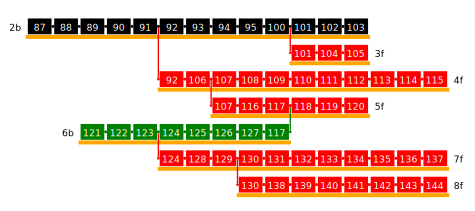

In [40]:
view = tree.renderer
view.zoom = 1.1
view.scale_y = 24
view.scale_x = 24
view.font_size = 0.35
SVG(view.to_svg())

An alternate view which is similar to the standard way of plotting

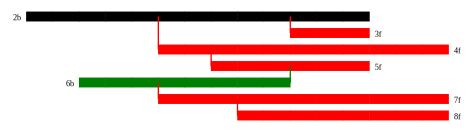

In [41]:
tree.rejected = False
tree.states = []
tree.op = None
tree.from_samples(samps)
view = tree.renderer
view.zoom = 1.1
view.horizontal_gap = -0.01
view.scale_y = 15
view.scale_x = 24
view.font_size = 0.5
view.font_family = 'Times'
SVG(view.to_svg())

### Phi/Psi Plots

In [42]:
# Imports for plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.legend_handler import HandlerLine2D

import numpy as np

degrees = 180/3.14159

Make sure that all phi/psi values have been computed!

In [43]:
psi = storage.cvs[0]
phi = storage.cvs[1]

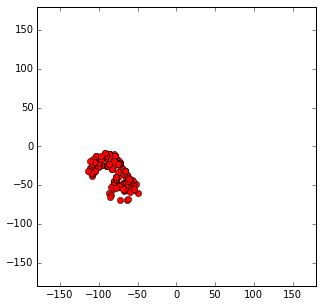

In [44]:
plt.figure(figsize=(5, 5))

for traj in storage.trajectories.iterator():
    phi_angles = degrees * np.array(phi(traj)).flatten()
    psi_angles = degrees * np.array(psi(traj)).flatten()
    plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    
plt.xlim(-180, 180);
plt.ylim(-180, 180);

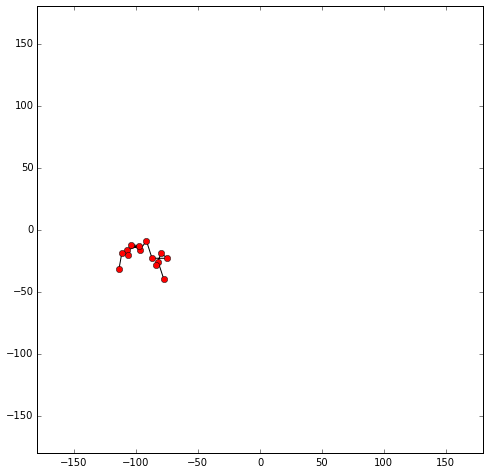

In [45]:
plt.figure(figsize=(8, 8))

traj = storage.trajectories.last()
phi_angles = degrees * np.array(phi(traj)).flatten()
psi_angles = degrees * np.array(psi(traj)).flatten()
plt.plot(phi_angles, psi_angles, 'k-', linewidth=1);

op_notinAorB = storage.cvs[4]

for snapshot in traj:
    phi_angles = degrees * np.array(phi(snapshot)).flatten()
    psi_angles = degrees * np.array(psi(snapshot)).flatten()
    if op_notinAorB(snapshot):
        plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    else:
        plt.plot(phi_angles, psi_angles, 'bo', linewidth=1);
        
plt.xlim(-180, 180);
plt.ylim(-180, 180);

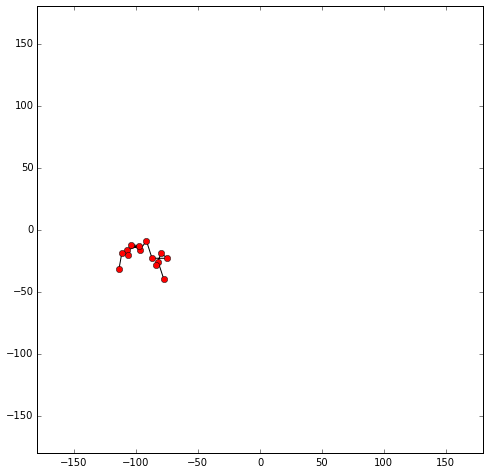

In [46]:
plt.figure(figsize=(8, 8))

traj = storage.samples.last().trajectory
phi_angles = degrees * np.array(phi(traj)).flatten()
psi_angles = degrees * np.array(psi(traj)).flatten()
plt.plot(phi_angles, psi_angles, 'k-', linewidth=1);


#for snapshot in simulator.storage.snapshot.iterator():
for snapshot in traj:
    phi_angles = degrees * np.array(phi(snapshot)).flatten()
    psi_angles = degrees * np.array(psi(snapshot)).flatten()
    if op_notinAorB(snapshot):
        plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    else:
        plt.plot(phi_angles, psi_angles, 'bo', linewidth=1);
        
plt.xlim(-180, 180);
plt.ylim(-180, 180);